In [696]:
import os
import sys
sys.path.append("./..")
from utils import PROJECT_ROOT
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import networkx as nx
from matplotlib.lines import Line2D
import pandas as pd
from c_Population_graph.population_graph import construct_PopulationGraph
from c_Population_graph.community_detection import detect_communities
from e_Survival_analysis.survival_analysis import calculate_hazard_ratio
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test
from overpresented_patterns import calculate_relative_presentation

In [697]:
iteration = 2
PhenoGraph_k =  30
size_smallest_cluster = 20
survival_type = 'Overall'
PopulationGraph_type = 'knn_graph'
para_dict = {
    'weight_threshold_percentile': 90,
    'knn_k':10
}
Subset_filtering = {
}

In [698]:
SoftWL_dict= pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel",
            "Danenberg",
            "Cohort_1",
            "SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + ".pkl",
        ),
        "rb",
    ),
)
Patient_IDs = SoftWL_dict["Patient_id"]
Gram_matrix = SoftWL_dict["Gram_matrix"]
Histograms = SoftWL_dict["Histogram"]
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)
clinical['Overall Survival Status'] = clinical['Overall Survival Status'].map({'0:LIVING':0, '1:DECEASED':1})
clinical['Relapse Free Status'] = clinical['Relapse Free Status'].map({'0:Not Recurred':0, '1:Recurred':1})
clinical['Disease-specific Survival Status'] = clinical['Disease-specific Survival Status'].map({'0:LIVING':0, '1:DECEASED':1})

In [699]:
G_population = construct_PopulationGraph(
    Gram_matrix,
    PopulationGraph_type,
    para_dict = para_dict,
)
Community_ids = detect_communities(G_population, size_smallest_cluster)

In [700]:
if survival_type == 'Overall':
    Length = [clinical.loc[clinical['patient_id'] == i, 'Overall Survival (Months)'].values[0] for i in Patient_IDs]
    Status = [clinical.loc[clinical['patient_id'] == i, 'Overall Survival Status'].values[0] for i in Patient_IDs]  
elif survival_type == 'Relpase-free':
    Length = [clinical.loc[clinical['patient_id'] == i, 'Relapse Free Status (Months)'].values[0] for i in Patient_IDs]
    Status = [clinical.loc[clinical['patient_id'] == i, 'Relapse Free Status'].values[0] for i in Patient_IDs] 
elif survival_type == 'Disease-specific':
    Length = [clinical.loc[clinical['patient_id'] == i, 'Disease-specific Survival (Months)'].values[0] for i in Patient_IDs]
    Status = [clinical.loc[clinical['patient_id'] == i, 'Disease-specific Survival Status'].values[0] for i in Patient_IDs]
DF = pd.DataFrame({"Length": Length, "Status": Status, "Community_ids": Community_ids}).dropna()
Length_ = np.array(DF["Length"])
Status_ = np.array(DF["Status"])
Community_ids_ = np.array(DF["Community_ids"])
Histograms_ = Histograms[DF.index.values, :]
Patient_IDs_ = np.array(Patient_IDs)[DF.index.values]
HR = calculate_hazard_ratio(Length_, Status_, Community_ids_)
HR = sorted(HR, key=lambda x: x["hr"], reverse=True)
Subgroup_ids = np.zeros_like(Community_ids)
Subgroup_ids_ = np.zeros_like(Community_ids_)
for i in range(len(HR)):
    Subgroup_ids[Community_ids == HR[i]["community_id"]] = i + 1
    Subgroup_ids_[Community_ids_ == HR[i]["community_id"]] = i + 1
    HR[i]["subgroup_id"] = i + 1
for i in range(len(HR)):
    print("S{}:".format(HR[i]['subgroup_id']))
    print("Survival: hr = {}, p = {}".format(HR[i]["hr"], HR[i]["p"]))

S1:
Survival: hr = 1.7549071575589084, p = 0.03213630831783725
S2:
Survival: hr = 1.7244139979329198, p = 0.05960097478078516
S3:
Survival: hr = 1.659446668393116, p = 0.006629647173866533
S4:
Survival: hr = 1.4286735236059445, p = 0.23481030748151963
S5:
Survival: hr = 1.338894007817867, p = 0.2949374367635713
S6:
Survival: hr = 1.1824735190269005, p = 0.48028557873239497
S7:
Survival: hr = 0.9131144830867252, p = 0.7441467087895823
S8:
Survival: hr = 0.8507460240028772, p = 0.5054835908392487
S9:
Survival: hr = 0.7406391994628188, p = 0.23912662241208843
S10:
Survival: hr = 0.4475975768606393, p = 0.0765035330790078
S11:
Survival: hr = 0.44010742768934996, p = 0.03334010985219879
S12:
Survival: hr = 0.3767823829642346, p = 0.011535145078114296


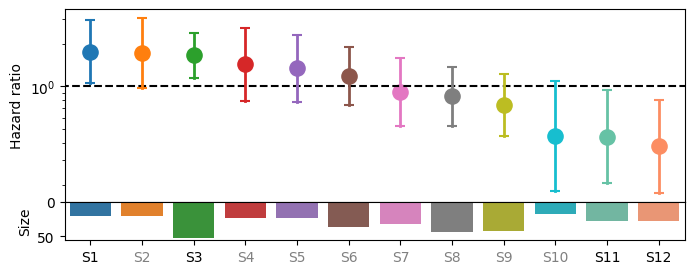

In [701]:
# Plot hazard ratio
num_significant = 0
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
f, ax = plt.subplots(2, 1, height_ratios=[5, 1], figsize=(8, 3), sharex=True)
f.subplots_adjust(hspace=0)
ax[0].hlines(1, -1, len(HR), color="k", linestyle="--")
N, xticklabels, xtickcolors = [], [], []
for i in range(len(HR)):
    hr_dict = HR[i]
    subgroup_id = hr_dict['subgroup_id']
    hr, hr_lb, hr_ub, p = (
            hr_dict["hr"],
            hr_dict["hr_lower"],
            hr_dict["hr_upper"],
            hr_dict["p"],
        )
    ax[0].plot([i, i], [hr_lb, hr_ub], color=color_palette[i], linewidth=2)
    ax[0].scatter([i], [hr], color=color_palette[i], s=120)
    ax[0].scatter([i], [hr_lb], color=color_palette[i], s=60, marker="_")
    ax[0].scatter([i], [hr_ub], color=color_palette[i], s=60, marker="_")
    N.append(np.sum(Subgroup_ids_ == subgroup_id))
    xticklabels.append("S{}".format(int(subgroup_id)))
    if p < 0.05:
        xtickcolors.append("k")
        num_significant+=1
    else:
        xtickcolors.append("grey")
ax[0].set_xticks(range(len(HR)))
ax[0].set_xticklabels(xticklabels)
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[0].set_xlabel("Patient Subgroups")
ax[0].set_ylabel("Hazard ratio")
ax[0].set_yscale("log")
# ax[1].set_title("Hazard ratios of Patient Subgroups")
DF = pd.DataFrame({"N": N, "subgroup_id": xticklabels})
g = sns.barplot(data=DF, x="subgroup_id", y="N", palette=color_palette, ax=ax[1])
g.invert_yaxis()
ax[1].set_ylabel("Size")
ax[1].set_xlabel("")
plt.show()

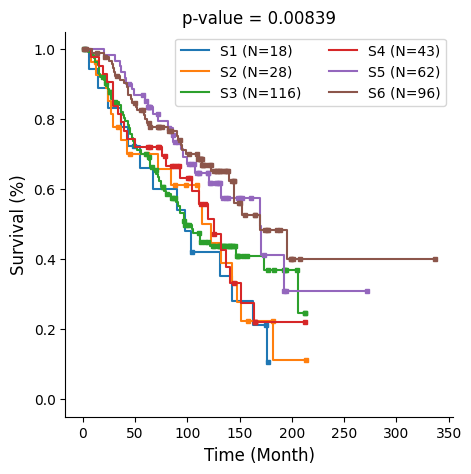

In [689]:

kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5, 5))
for i, hr_dict in enumerate(HR):
    subgroup_id = hr_dict['subgroup_id']
    length_A, event_observed_A = (
            Length_[Subgroup_ids_ == subgroup_id],
            Status_[Subgroup_ids_ == subgroup_id],
        )
    label = "S{} (N={})".format(hr_dict["subgroup_id"], np.sum(Subgroup_ids_ == subgroup_id))
    kmf.fit(length_A, event_observed_A, label=label)
    kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[i],
    show_censors=True,
            censor_styles={"ms": 3, "marker": "s"})
log_rank_test  = multivariate_logrank_test(
        Length_[Subgroup_ids_!=0], Subgroup_ids_[Subgroup_ids_!=0],Status_[Subgroup_ids_!=0]
    )
p_value = log_rank_test.p_value
ax.legend(ncol=2, fontsize = 10)
ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()

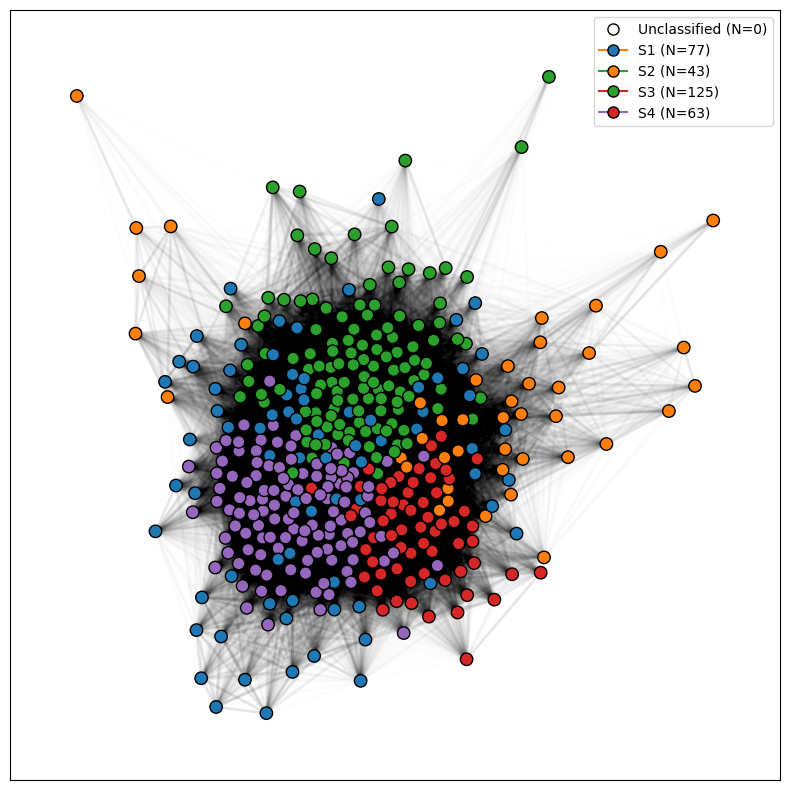

In [682]:
color_palette = ["white"] + sns.color_palette("tab10") + sns.color_palette("Set2")
pos = nx.spring_layout(G_population, seed=2, k=1 / np.sqrt(682) * 5, iterations=100)
fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)
edge_list = list(G_population.edges())
edge_alpha = [
        0.1 * G_population[u][v]["weight"] if G_population[u][v]["weight"] > 0 else 0 for u, v in edge_list
    ]
nx.draw_networkx_edges(G_population, pos, alpha=edge_alpha, width=2)
nx.draw_networkx_nodes(
            G_population, pos, node_size=80, 
            node_color=[color_palette[int(i)] for i in Subgroup_ids], 
            edgecolors="black"
        )
handles = [
    Line2D(
        [0],
        [0],
        marker="o",
        color=color_palette[0],
        label=f"Unclassified (N={np.sum(Subgroup_ids == 0)})",
        markerfacecolor=color_palette[0],
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    )
]
for i in range(1, len(np.unique(Subgroup_ids))):
    patch = Line2D(
        [0],
        [0],
        marker="o",
        color=color_palette[i + 1],
        label=f"S{i} (N={np.sum(Subgroup_ids == i)})",
        markerfacecolor=color_palette[i],
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    )
    handles.append(patch)
ax.legend(handles=handles)
plt.show()

### Candidates for prognosis-relevant patterns: overpresented

In [690]:
Candidates = []
Candiates_overpresented_in_subgroup = []
from scipy import stats
for hr_dict in HR:
    subgroup_id = hr_dict["subgroup_id"]
    hr = hr_dict["hr"]
    p = hr_dict["p"]
    if p < 0.05:
        Histogram_intra_group = Histograms_[Subgroup_ids_ == subgroup_id]
        Histogram_out_group = Histograms_[Subgroup_ids_ != subgroup_id]
        for i in range(Histograms_.shape[1]):
            rvsi = Histogram_intra_group[:, i]
            rvso = Histogram_out_group[:, i]
            ratio = np.mean(rvsi) / np.mean(rvso)
            result = stats.ttest_ind(rvsi, rvso, equal_var=False)
            if (result.pvalue < 0.05/Histograms_.shape[1]) and (ratio > 5):
                print(
                        "Pattern {} overpresented in {} by {:.3f} times (p={:.5f})".format(
                            i,subgroup_id,  ratio, result.pvalue
                        )
                    )
                Candidates.append(i)
                Candiates_overpresented_in_subgroup.append(subgroup_id)
                
                    
print(Candidates)              
print(Candiates_overpresented_in_subgroup)



Pattern 10 overpresented in 6 by 6.730 times (p=0.00000)
Pattern 16 overpresented in 6 by 13.472 times (p=0.00000)
Pattern 18 overpresented in 6 by 10.813 times (p=0.00000)
Pattern 23 overpresented in 6 by 23.668 times (p=0.00000)
Pattern 28 overpresented in 6 by 7.886 times (p=0.00002)
Pattern 35 overpresented in 6 by 13.147 times (p=0.00003)
Pattern 45 overpresented in 6 by 5.221 times (p=0.00037)
Pattern 51 overpresented in 6 by 5.771 times (p=0.00027)
Pattern 60 overpresented in 6 by 31.416 times (p=0.00056)
[10, 16, 18, 23, 28, 35, 45, 51, 60]
[6, 6, 6, 6, 6, 6, 6, 6, 6]


In [521]:
# Histograms_ = (Histograms_ - np.mean(Histograms_, axis=0))/np.std(Histograms_, axis=0)
DF = pd.DataFrame({
    'length': Length_,
    'status': Status_,
})
for pattern_id in Candidates:
    DF["pattern_"+str(pattern_id)] = Histograms_[:, pattern_id]
cph = CoxPHFitter()
cph.fit(DF, duration_col='length', event_col='status', formula=" + ".join(["pattern_"+str(i) for i in Candidates]))
print(cph.print_summary())

<lifelines.CoxPHFitter: fitted with 369 total observations, 189 right-censored observations>
             duration col = 'length'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 369
number of events observed = 180
   partial log-likelihood = -938.75
         time fit was run = 2023-11-03 01:07:38 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
pattern_10  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
pattern_15  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
pattern_16   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
pattern_18   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
pattern_22  -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
pattern_23  -0.00       1.00       0.00            -0.01            -0.00                 0.99                 1.00
pattern_28   0.00       1.00       0.00             0.00             0.01                 1.00                 1.01
pattern_35  -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00

             cmp to     z    p   -log2(p)
covariate                                
pattern_10     0.00 -0.16 0.88       0.19
pattern_15     0.00 -0.92 0.36       1.49
pattern_16     0.00  1.60 0.11       3.20
pattern_18     0.00  0.48 0.63       0.66
pattern_22     0.00 -1.67 0.09       3.40
pattern_23     0.00 -2.08 0.04       4.74
pattern_28     0.00  2.67 0.01       7.04
pattern_35     0.00 -1.84 0.07       3.92
---
Concordance = 0.59
Partial AIC = 1893.49
log-likelihood ratio test = 19.64 on 8 df
-log2(p) of ll-ratio test = 6.41

None


In [499]:
for pattern_id in Candidates:
    histogram_pattern = Histograms_[:, pattern_id]
    # print(
    #     "min = {}, max = {}, 25-percentile = {}, 50 percentile = {}, 90 percentile = {}".format(
    #         np.min(histogram_pattern),
    #         np.max(histogram_pattern),
    #         np.percentile(histogram_pattern, 25),
    #         np.percentile(histogram_pattern, 50),
    #         np.percentile(histogram_pattern, 90),
    #     )
    # )
    high_threshold = 0#np.percentile(histogram_pattern, 75)
    low_threshold = 0#np.percentile(histogram_pattern, 25)
    kmf = KaplanMeierFitter()
    
    length_A, event_observed_A = (
        Length_[histogram_pattern > high_threshold],
        Status_[histogram_pattern > high_threshold],
    )
    length_B, event_observed_B = (
        Length_[histogram_pattern <= low_threshold],
        Status_[histogram_pattern <= low_threshold],
    )
    # length_C, event_observed_C = (
    #     Length_[
    #         (histogram_pattern > low_threshold) & (histogram_pattern < high_threshold)
    #     ],
    #     Status_[
    #         (histogram_pattern > low_threshold) & (histogram_pattern < high_threshold)
    #     ],
    # )
    log_rank_test = multivariate_logrank_test(
        np.concatenate([length_A, length_B]),
        [0] * len(length_A) + [1] * len(length_B) ,
        np.concatenate([event_observed_A, event_observed_B]),
    )
    p_value = log_rank_test.p_value
    if p_value :
        print(pattern_id, np.percentile(histogram_pattern, 75), np.percentile(histogram_pattern, 25))
        f, ax = plt.subplots(figsize=(5, 5))
        kmf.fit(length_A, event_observed_A, label="Positive (N={})".format(len(length_A)))
        kmf.plot_survival_function(
            ax=ax,
            ci_show=False,
            color="red",
            show_censors=True,
            censor_styles={"ms": 3, "marker": "s"},
        )

        kmf.fit(length_B, event_observed_B, label=" Negative (N={})".format(len(length_B)))
        kmf.plot_survival_function(
            ax=ax,
            ci_show=False,
            color=color_palette[1],
            show_censors=True,
            censor_styles={"ms": 3, "marker": "s"},
        )
        # kmf.fit(length_C, event_observed_C, label="Low (N={})".format(len(length_C)))
        # kmf.plot_survival_function(
        #     ax=ax,
        #     ci_show=False,
        #     color=color_palette[3],
        #     show_censors=True,
        #     censor_styles={"ms": 3, "marker": "s"},
        # )
        ax.legend(ncol=2, fontsize=10)
        ax.set_title("Pattern {}, p-value = {:.7f}".format(pattern_id, p_value), fontsize=12)
        ax.set_xlabel("Time (Month)", fontsize=12)
        ax.set_ylabel("Survival (%)", fontsize=12)
        ax.set(
                ylim=(-0.05, 1.05),
            )
        sns.despine()